In [1]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(RColorBrewer)
library(pheatmap)
library(umap)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [31]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
count_files <- Sys.glob(paths = paste0(dirs$data_dir, "/TCGA_RNA_matrix_count_data", "/*counts.tsv"))
coldata_files <- Sys.glob(paths = paste0(dirs$data_dir, "/TCGA_RNA_matrix_count_data", "/*coldata.tsv"))

count_files
coldata_files

[1] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-CESC_counts.tsv"
[2] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-OV_counts.tsv"  
[3] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-UCEC_counts.tsv"
[4] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-UCS_counts.tsv"

[1] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-CESC_coldata.tsv"
[2] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-OV_coldata.tsv"  
[3] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-UCEC_coldata.tsv"
[4] "/mnt/d/fogg_lab_gyn_cancer_data/TCGA_RNA_matrix_count_data/TCGA-UCS_coldata.tsv"

# Load data

In [14]:
data_ls <- rutils::load_and_combine_count_matrix_data(
    count_files,
    coldata_files,
    count_join_symbols = c("ensembl_gene_id", "external_gene_name")
)

# Separate out counts & coldata
# Also, for this analysis, we only care about tumor data
coldata_df <- data_ls$coldata_df %>%
    dplyr::filter(condition == "Primary solid Tumor")
counts_df <- data_ls$counts_df %>%
    dplyr::select(ensembl_gene_id, external_gene_name, coldata_df$sample_name)
all(coldata_df$sample_name == colnames(counts_df)[-c(1:2)])

Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character()

In [21]:
matrisome_df <- rutils::load_matrisome_df(
    paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")
)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


# Filter and normalize

Experiment with whether to filter or normalize first

## Pre-filter lowly expressed genes

In [22]:
# filter genes which are never expressed in any sample
unexpressed_mask <- !(rowSums(counts_df[, -c(1:2)] > 0) == 0)
expressed_counts_df <- counts_df[unexpressed_mask, ]
nrow(expressed_counts_df)

[1] 55065

In [23]:
# Drop genes whose expressions are at or below the median in 75% of samples
expr_med <- median(as.matrix(expressed_counts_df[, -c(1:2)]))
lowly_expressed_mask <- !(rowSums(expressed_counts_df[, -c(1:2)] <= expr_med) > (.75 * nrow(coldata_df)))
prefiltered_counts_df <- expressed_counts_df[lowly_expressed_mask, ]

# Remaining genes
nrow(prefiltered_counts_df)

[1] 29319

## Filter to matrisome genes

In [24]:
matrisome_mask <- prefiltered_counts_df$external_gene_name %in% matrisome_df$gene_symbol
filtered_counts_df <- prefiltered_counts_df[matrisome_mask, ]

# Remaining genes
nrow(filtered_counts_df)

[1] 895

In [25]:
# No repeats?
nrow(filtered_counts_df) == length(unique(filtered_counts_df$external_gene_name))

# Drop ensembl gene ids
filtered_counts_df <- dplyr::select(filtered_counts_df, -ensembl_gene_id)

[1] TRUE

## Normalize using VST

In [26]:
filtered_counts <- filtered_counts_df %>%
    column_to_rownames(var = "external_gene_name") %>%
    as.matrix()

In [27]:
norm_filtered_counts <- varianceStabilizingTransformation(filtered_counts, blind = TRUE)

converting counts to integer mode


In [28]:
norm_filtered_counts_df <- norm_filtered_counts %>%
    as_tibble(rownames = "external_gene_name")

# Heatmaps

## Get representative group samples

In [36]:
centroids <- get_group_centroids(
    norm_filtered_counts_df, coldata_df, 
    projects, 
    "project", 
    "sample_name"
)
hm_sample_meta_df <- balanced_group_sample(
    norm_filtered_counts, 
    coldata_df, 
    centroids, 
    projects, 
    n = 10, 
    "project", 
    "sample_name"
)

[1] 10  3
[1] 10  3
[1] 10  3
[1] 10  3


In [37]:
hm_sample_counts_df <- norm_filtered_counts_df[, c("external_gene_name", hm_sample_meta_df$sample_name)] %>%
    column_to_rownames(var = "external_gene_name")
hm_sample_coldata_df <- coldata_df %>%
    dplyr::filter(sample_name %in% hm_sample_meta_df$sample_name) %>%
    arrange(match(sample_name, hm_sample_meta_df$sample_name)) %>%
    column_to_rownames(var = "sample_name")# Heatmap needs row names

In [38]:
# hm sample column data should line up with counts
all(colnames(hm_sample_counts_df) == rownames(hm_sample_coldata_df))

[1] TRUE

## Drop genes with near-zero SD

In [39]:
gene_sd_mask <- rowSds(as.matrix(hm_sample_counts_df)) > 1e-10
filtered_hm_sample_counts_df <- hm_sample_counts_df[gene_sd_mask, ]

## Compute distances

In [40]:
col_dist <- as.dist(1 - cor(as.matrix(filtered_hm_sample_counts_df), method = "spearman"))
row_dist <- as.dist(1 - cor(t(as.matrix(filtered_hm_sample_counts_df)), method = "pearson"))

col_clust <- hclust(col_dist, method = "complete")
row_clust <- hclust(row_dist, method = "complete")

In [41]:
z_score_mat <- t(apply(filtered_hm_sample_counts_df, 1, rutils::get_z_score))

In [42]:
proj_colors <- list(project = brewer.pal(n = 4, name = "Set1"))
names(proj_colors$project) <- unique(hm_sample_coldata_df$project)

png 
  2

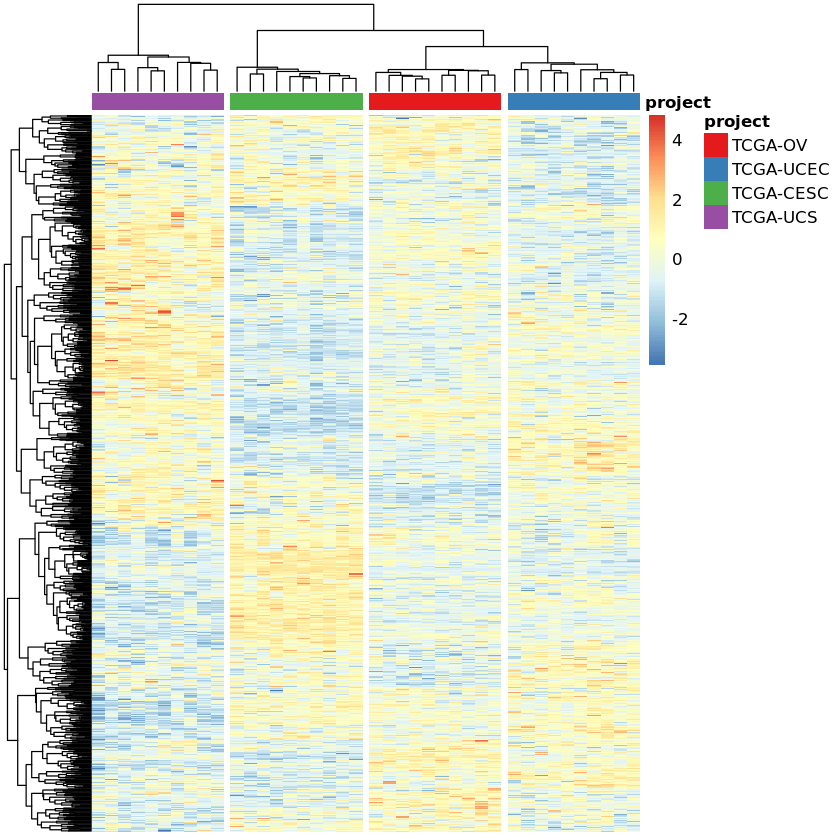

In [46]:
hm <- pheatmap(
    z_score_mat,
    cluster_rows = row_clust,
    cluster_cols = col_clust,
    cutree_cols = 4,
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = hm_sample_coldata_df["project"],
    annotation_colors = proj_colors
)

# png(paste0(data_root, "/TCGA/figures/heatmap.png"))
png(paste0(dirs$figures_dir, "/all_gyn_heatmap.png"))
grid::grid.newpage()
grid::grid.draw(hm$gtable)
dev.off()

# PCA

In [47]:
pca_res <- prcomp(t(norm_filtered_counts), center = TRUE, scale. = FALSE)

In [48]:
pca_res_df <- pca_res$x %>%
    as_tibble(rownames = "sample_name") %>%
    mutate(project = coldata_df$project) %>%
    dplyr::select(sample_name, project, everything())

pca_var_df <- tibble(pc = colnames(pca_res$x)) %>%
    mutate(var = pca_res$sdev ^2) %>%
    mutate(pct_var = round(var / sum(var) * 100, 1)) %>%
    mutate(pc_fact = factor(colnames(pca_res$x), levels = colnames(pca_res$x)))

Saving 6.67 x 6.67 in image


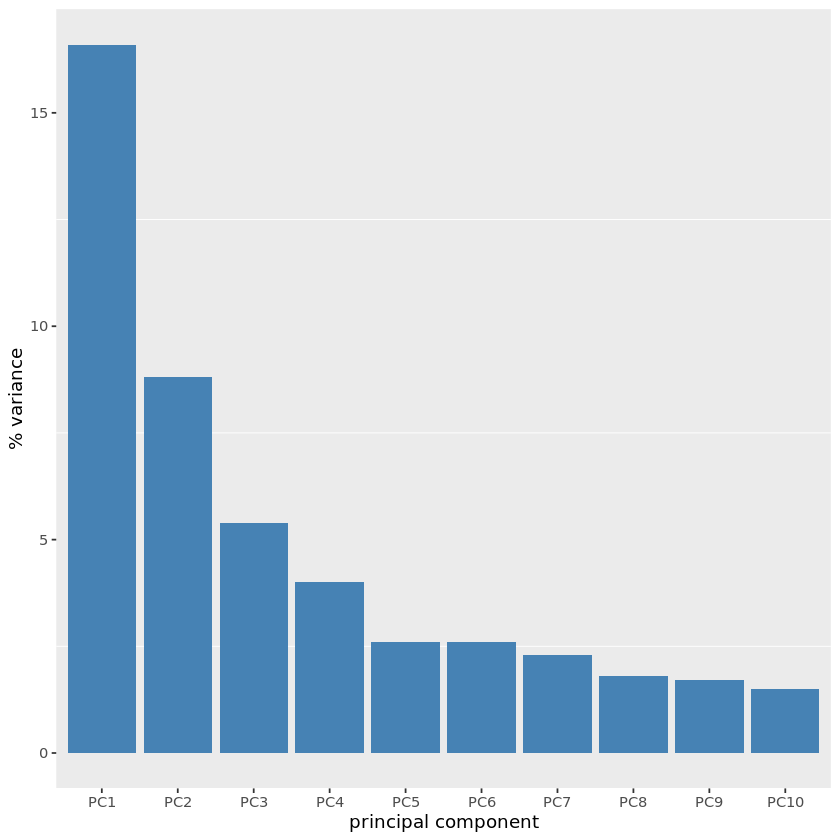

In [49]:
ggplot() +
    geom_bar(data = pca_var_df[1:10, ], aes(x = pc_fact, y = pct_var), stat = "identity", fill = "steelblue") +
    xlab(label = "principal component") +
    ylab(label = "% variance") +
    theme(panel.grid.major = element_blank())
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_screeplot.png"), last_plot())

In [50]:
pca_scatter <- function(df, pc_x, pc_y, pc_x_pctvar, pc_y_pctvar, col) {
    plt <- ggplot(df) +
        aes_string(x = pc_x, y = pc_y, color = col) +
        geom_point(size=1) +
        xlab(paste0(pc_x, " (", pc_x_pctvar, "%)")) + 
        ylab(paste0(pc_y, " (", pc_y_pctvar, "%)")) +
        coord_fixed()
    return(plt)
}

In [51]:
pca_var_df[1,]$pct_var

[1] 16.6

## Scatter plots

Saving 6.67 x 6.67 in image


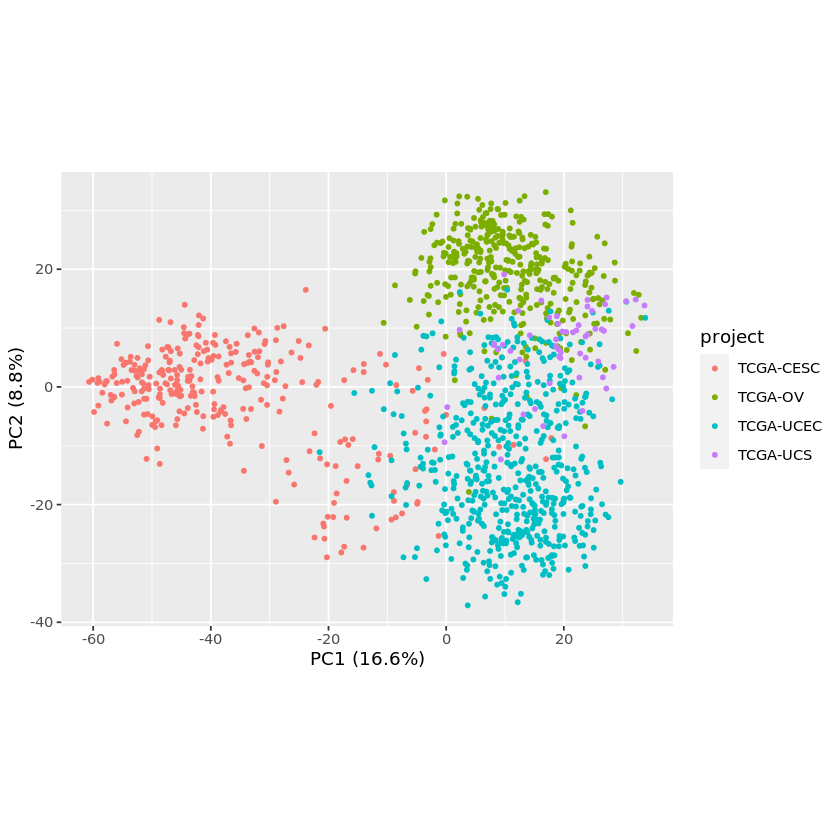

Saving 6.67 x 6.67 in image


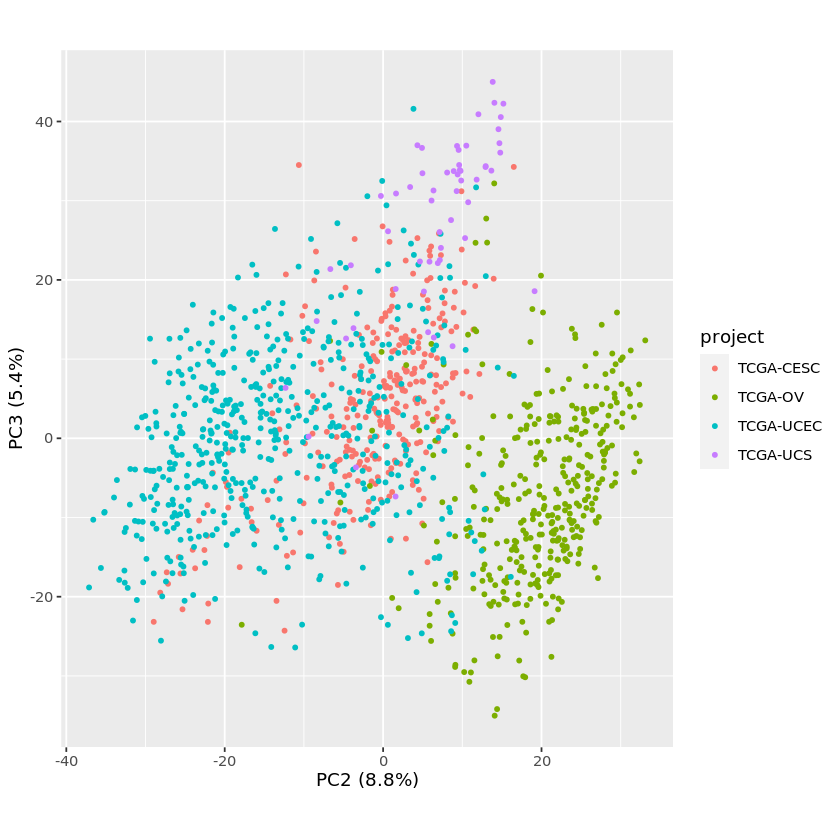

In [52]:
pca_scatter(pca_res_df, "PC1", "PC2", pca_var_df[1, ]$pct_var, pca_var_df[2, ]$pct_var, "project")
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_PC2_vs_PC1.png"), last_plot())
pca_scatter(pca_res_df, "PC2", "PC3", pca_var_df[2, ]$pct_var, pca_var_df[3, ]$pct_var, "project")
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_PC3_vs_PC2.png"), last_plot())

## Small multiples plots

In [53]:
pca_pivot_df <- pca_res_df%>%
    select(sample_name, PC1:PC4, project) %>%
    pivot_longer(cols = PC1:PC4, names_to = "PC", values_to = "loadings")
head(pca_pivot_df)

sample_name,project,PC,loadings
<chr>,<chr>,<chr>,<dbl>
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC1,-54.414996
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC2,4.114722
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC3,2.599954
TCGA-MY-A5BF-01A-11R-A26T-07,TCGA-CESC,PC4,1.679733
TCGA-EA-A3HU-01A-11R-A213-07,TCGA-CESC,PC1,-45.279393
TCGA-EA-A3HU-01A-11R-A213-07,TCGA-CESC,PC2,5.665924


Saving 6.67 x 6.67 in image


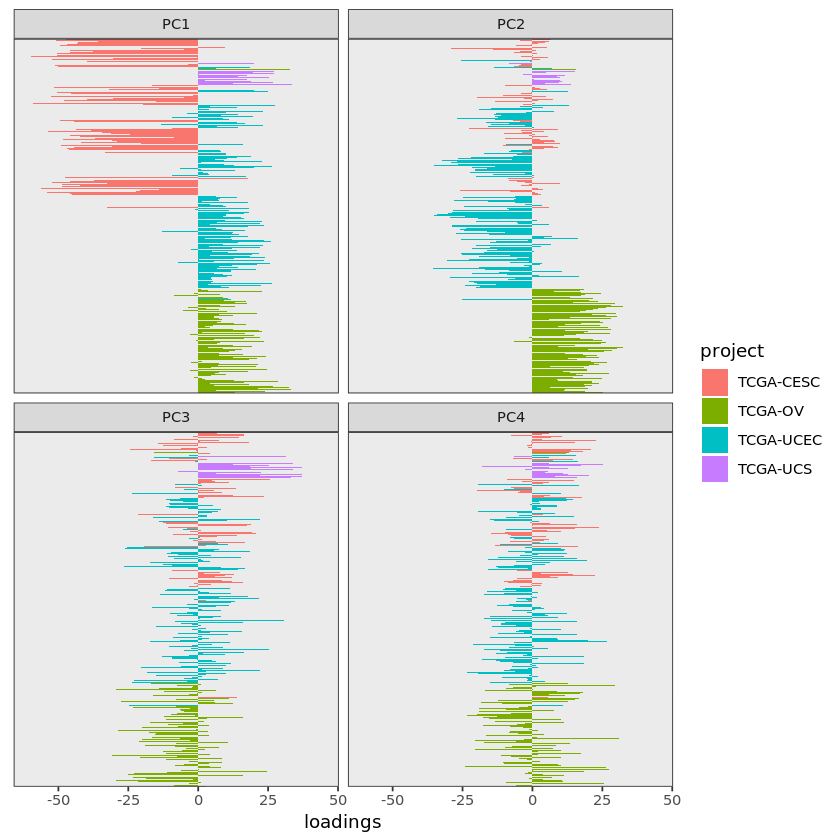

In [54]:
ggplot(pca_pivot_df) +
    aes(x=sample_name, y=loadings, fill=project) +
    geom_bar(stat="identity") +
    facet_wrap(~PC) +
    coord_flip() +
    theme_bw() + 
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    )
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_small_multiples_plot.png"), last_plot())

# UMAP

In [55]:
res_umap <- umap(t(norm_filtered_counts))

In [56]:
colnames(res_umap$layout) <- c("x1", "x2")
umap_df <- res_umap$layout %>%
    as_tibble() %>%
    bind_cols(coldata_df)
dim(umap_df)
head(umap_df)

[1] 1285    5

x1,x2,sample_name,condition,project
<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.1536564,6.270011,TCGA-MY-A5BF-01A-11R-A26T-07,Primary solid Tumor,TCGA-CESC
-0.5425012,5.908673,TCGA-EA-A3HU-01A-11R-A213-07,Primary solid Tumor,TCGA-CESC
-0.4360182,5.859121,TCGA-VS-A8EG-01A-11R-A36F-07,Primary solid Tumor,TCGA-CESC
-0.9340201,7.025938,TCGA-VS-A9UH-01A-11R-A42T-07,Primary solid Tumor,TCGA-CESC
-0.3241292,6.640404,TCGA-FU-A5XV-01A-11R-A28H-07,Primary solid Tumor,TCGA-CESC
-1.8738879,2.417086,TCGA-VS-A9UQ-01A-21R-A42T-07,Primary solid Tumor,TCGA-CESC


Saving 6.67 x 6.67 in image


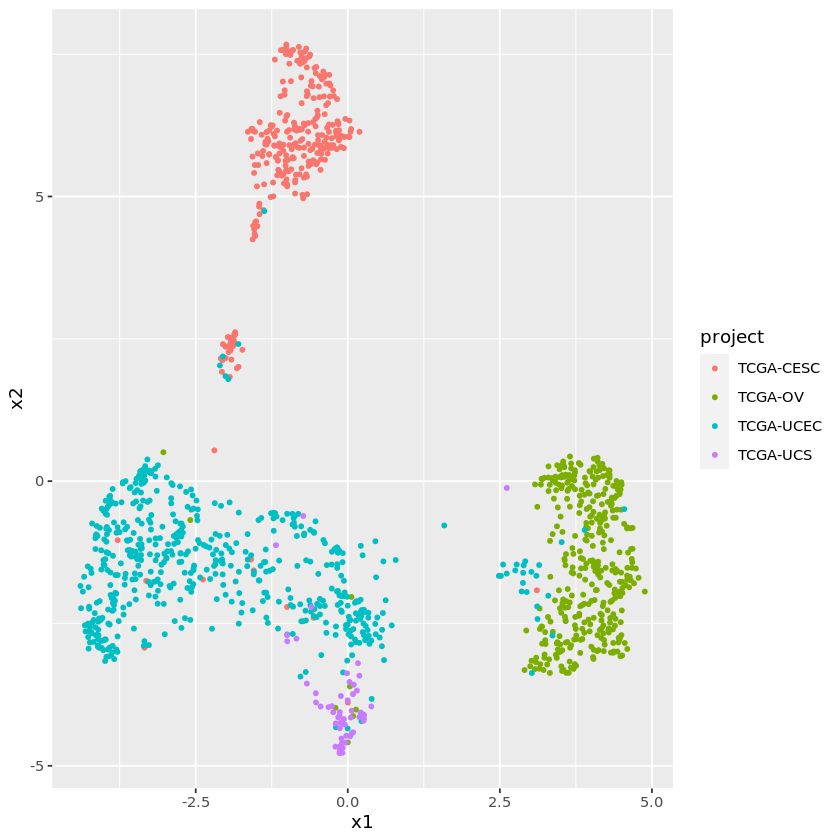

In [58]:
ggplot(umap_df) +
    aes(x = x1, y = x2, color = project) +
    geom_point(size=1)
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_umap.png"), last_plot())